# Lab 01: Simulating ODEs and SDEs

In [1]:
# Setup and Imports
import torch
import matplotlib.pyplot as plt
import numpy as np

# Import from our refactored library
from sde_lib import (
    # Processes
    BrownianMotion,
    OUProcess,
    LangevinSDE,
    # Simulators
    EulerMaruyamaSimulator,
    # Densities
    Gaussian,
    GaussianMixture,
    # Visualization
    plot_trajectories_1d,
    imshow_density,
    contour_density,
    plot_distribution_evolution,
    animate_distribution_evolution
)

# Device configuration
device = 'cpu'
print(f"Using device: {device}")

# Check library version
import sde_lib
print(f"SDE Library version: {sde_lib.__version__}")
print(f"Version info: {sde_lib.get_version_info()}")


Using device: cpu
SDE Library version: 1.0.0
Version info: {'sde_lib_version': '1.0.0', 'torch_version': '2.8.0', 'cuda_available': False, 'mps_available': True}


SDE Library - Quick Langevin Dynamics Demo

1. Creating target: 8-mode Gaussian mixture
2. Setting up Langevin dynamics (σ=0.7)
3. Initializing from broad Gaussian
4. Simulating 10000 particles for t∈[0, 10.0]
   Using 2000 timesteps (dt=0.0050)


Simulating: 100%|██████████| 1999/1999 [00:08<00:00, 237.86it/s]


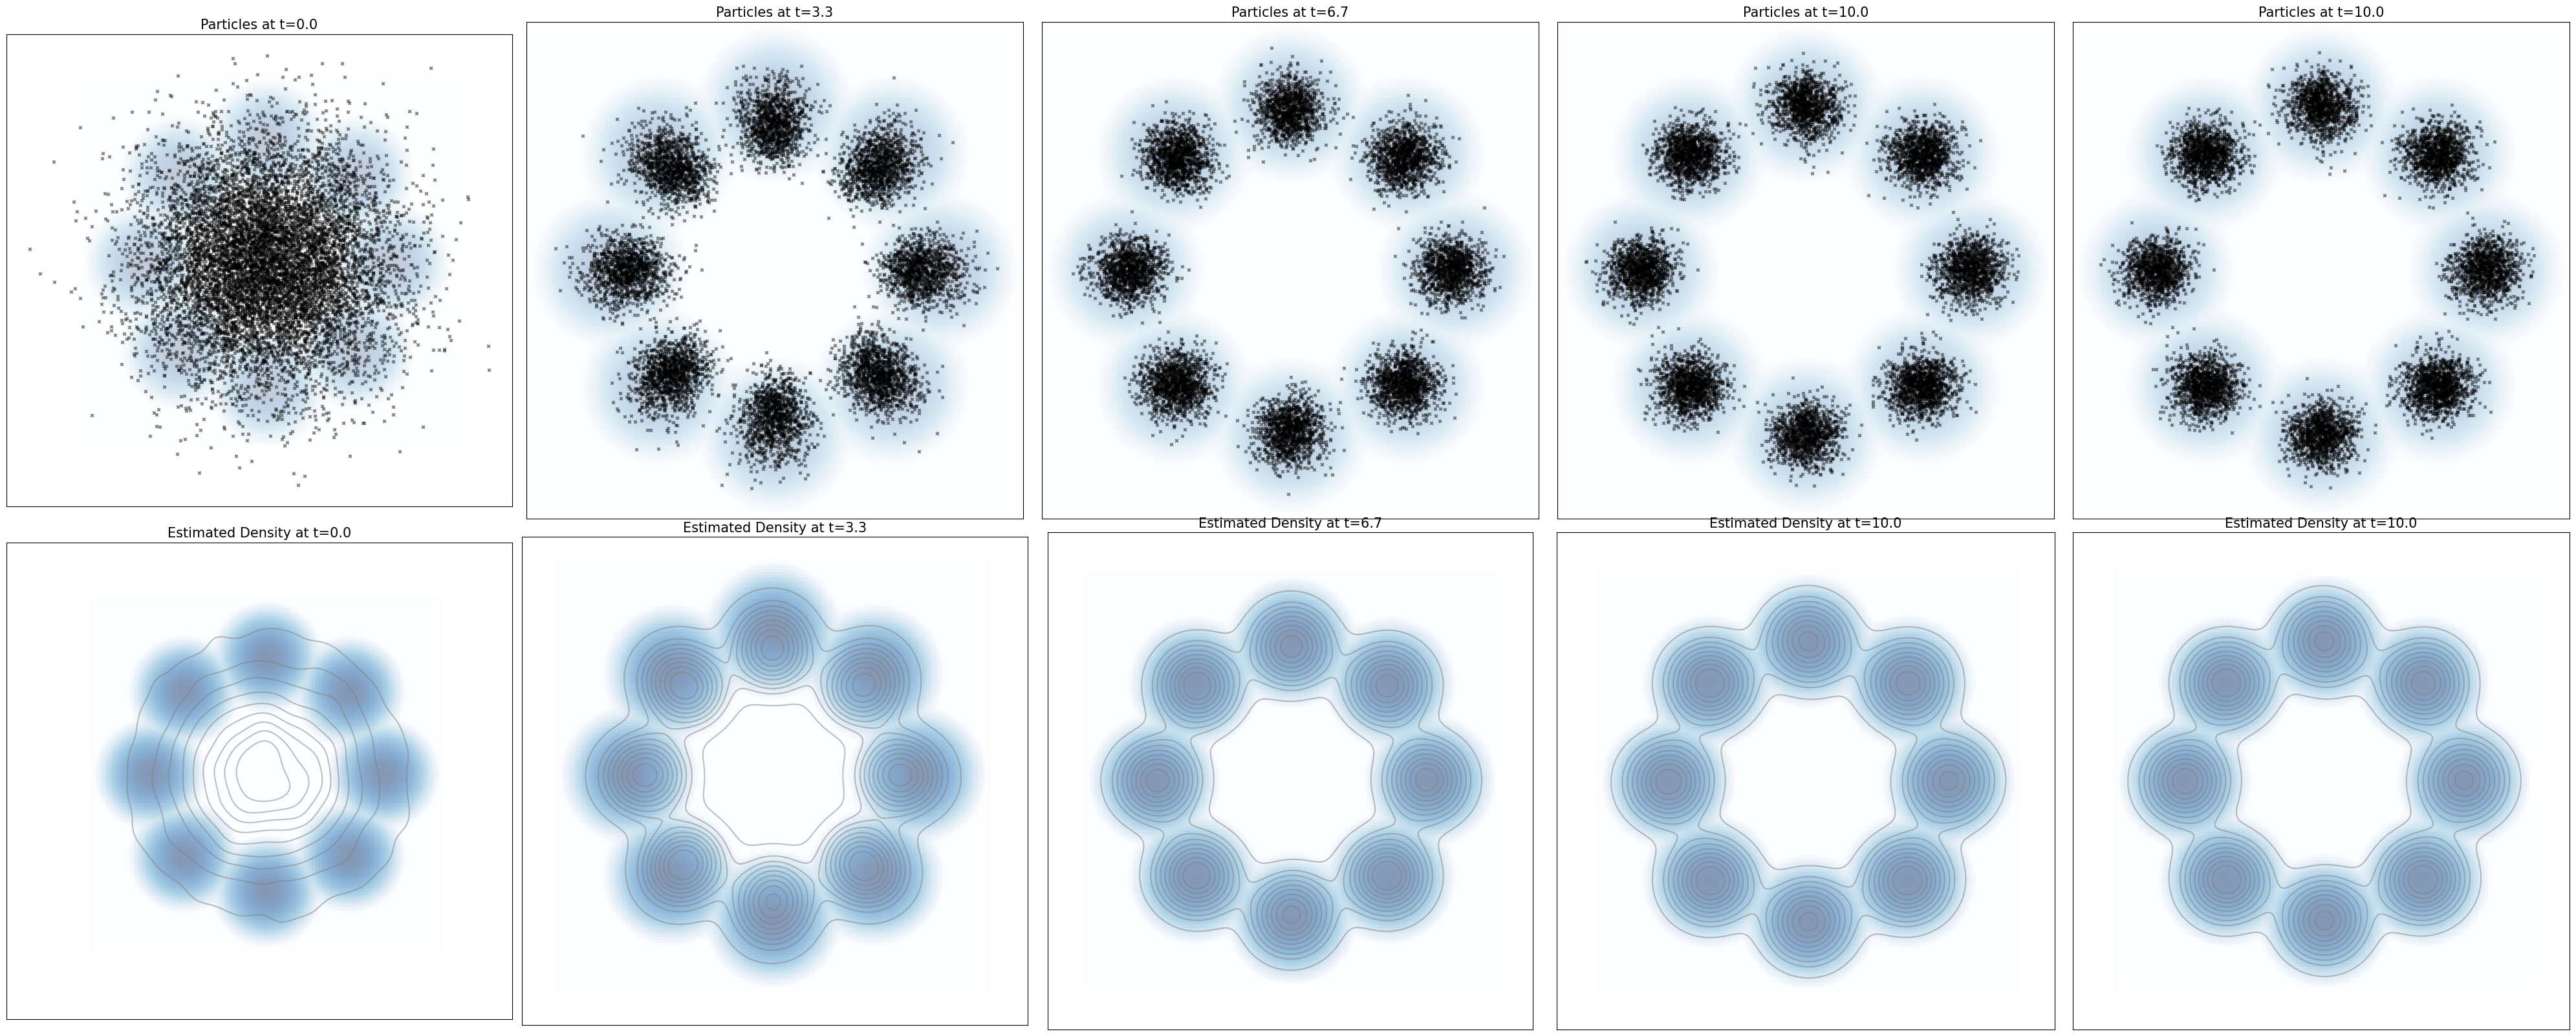


✓ Demo complete!


In [2]:
sde_lib.quick_langevin_demo(nmodes=8, num_samples=10000)

Part 1: Brownian Motion


Simulating: 100%|██████████| 499/499 [00:00<00:00, 46461.64it/s]


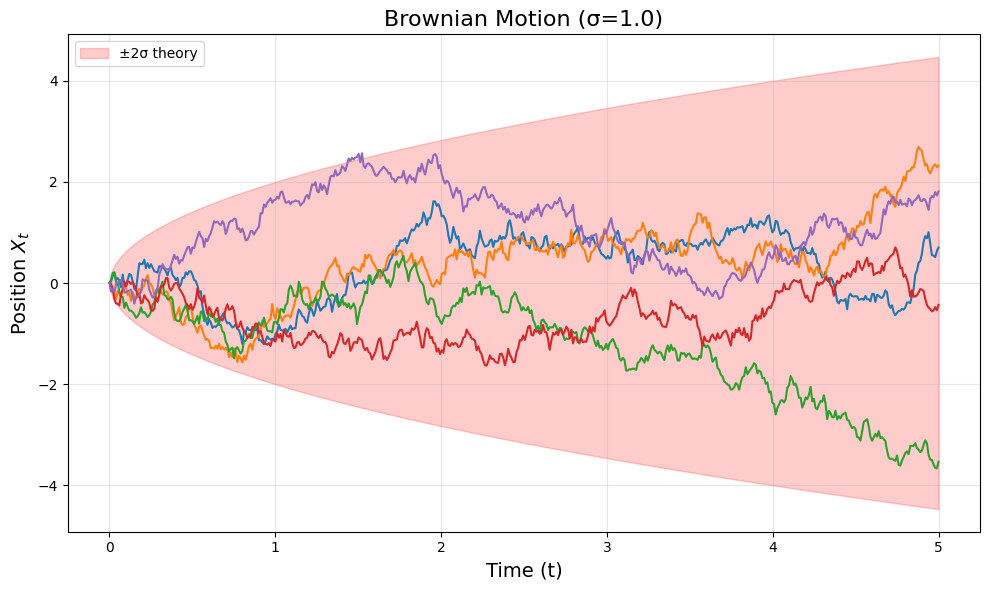

✓ Simulated 5 trajectories
  Theoretical std at t=5.0: 2.236


In [3]:
# Part 1 - Brownian Motion
"""
Brownian Motion: dX_t = σ dW_t

Pure diffusion with no drift. Variance grows linearly: Var(X_t) = σ²t
"""

print("=" * 60)
print("Part 1: Brownian Motion")
print("=" * 60)

# Parameters
sigma = 1.0
simulation_time = 5.0
num_particles = 5

# Create Brownian motion process
brownian = BrownianMotion(sigma=sigma)
simulator = EulerMaruyamaSimulator(sde=brownian)

# Initial conditions
x0 = torch.zeros(num_particles, 1).to(device)
ts = torch.linspace(0.0, simulation_time, 500).to(device)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title(f'Brownian Motion (σ={sigma})', fontsize=16)
ax.set_xlabel('Time (t)', fontsize=14)
ax.set_ylabel('Position $X_t$', fontsize=14)
ax.grid(True, alpha=0.3)
plot_trajectories_1d(x0, simulator, ts, ax)

# Theoretical variance line
t_vals = ts.cpu().numpy()
std_theory = sigma * np.sqrt(t_vals)
ax.fill_between(t_vals, -2*std_theory, 2*std_theory, 
                alpha=0.2, color='red', label='±2σ theory')
ax.legend()
plt.tight_layout()
plt.show()

print(f"✓ Simulated {num_particles} trajectories")
print(f"  Theoretical std at t={simulation_time}: {sigma * np.sqrt(simulation_time):.3f}")


Part 2: Ornstein-Uhlenbeck Process


Simulating: 100%|██████████| 999/999 [00:00<00:00, 65302.11it/s]


  Panel 1: θ=0.25, σ=0.0, equilibrium std=0.000


Simulating: 100%|██████████| 999/999 [00:00<00:00, 64981.08it/s]


  Panel 2: θ=0.25, σ=0.5, equilibrium std=0.707


Simulating: 100%|██████████| 999/999 [00:00<00:00, 70105.07it/s]


  Panel 3: θ=0.25, σ=1.0, equilibrium std=1.414


Simulating: 100%|██████████| 999/999 [00:00<00:00, 70886.65it/s]

  Panel 4: θ=0.5, σ=1.0, equilibrium std=1.000


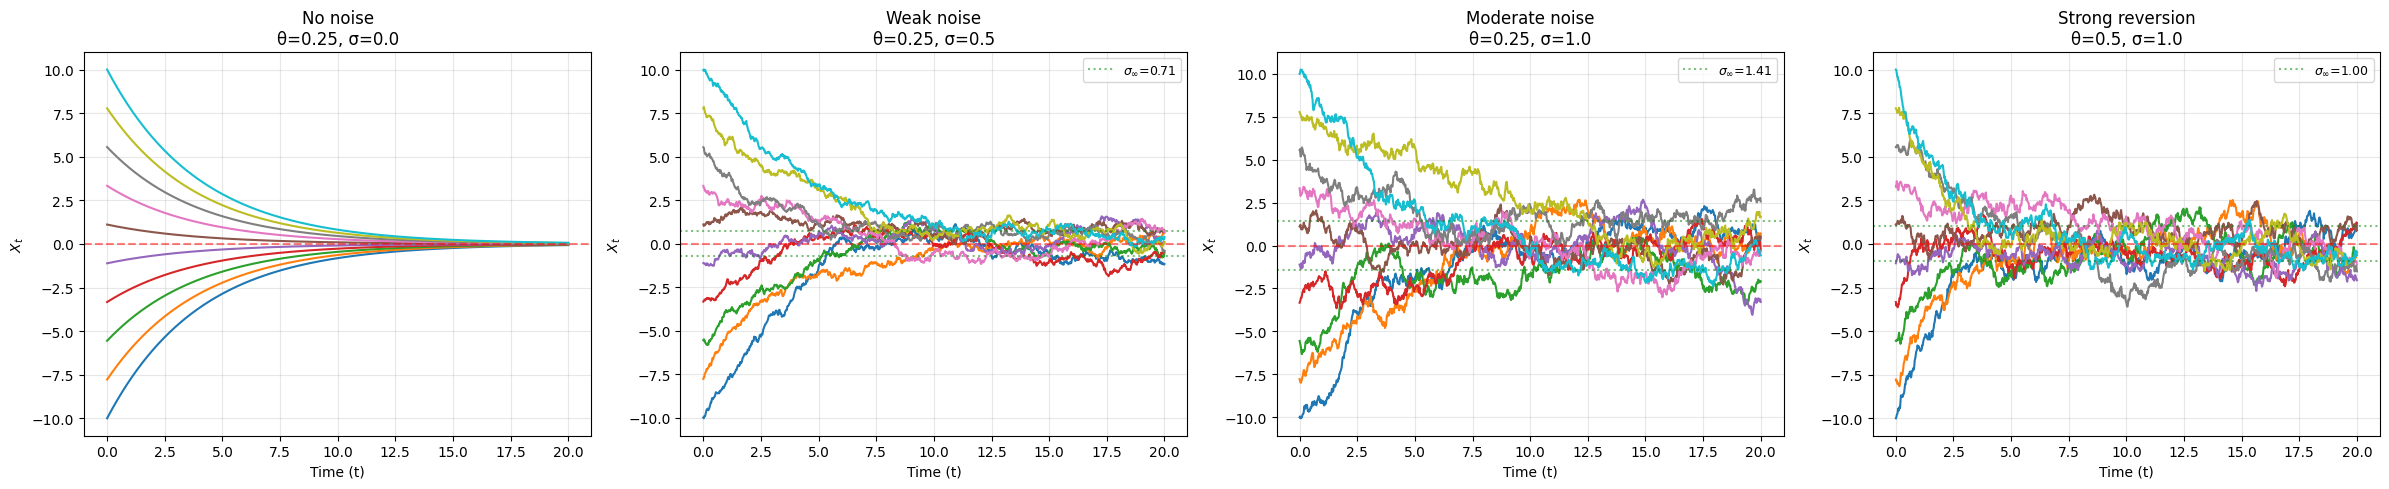

✓ OU process comparison complete


In [4]:
# Part 2 - Ornstein-Uhlenbeck Process
"""
Ornstein-Uhlenbeck Process: dX_t = -θX_t dt + σ dW_t

Mean-reverting process. Converges to N(0, σ²/(2θ))
"""

print("\n" + "=" * 60)
print("Part 2: Ornstein-Uhlenbeck Process")
print("=" * 60)

# Parameter sweep
thetas_and_sigmas = [
    (0.25, 0.0, "No noise"),
    (0.25, 0.5, "Weak noise"),
    (0.25, 1.0, "Moderate noise"),
    (0.50, 1.0, "Strong reversion"),
]

simulation_time = 20.0
num_plots = len(thetas_and_sigmas)
fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))

for idx, (theta, sigma, label) in enumerate(thetas_and_sigmas):
    # Create OU process
    ou = OUProcess(theta=theta, sigma=sigma)
    simulator = EulerMaruyamaSimulator(sde=ou)
    
    # Initial conditions (spread out)
    x0 = torch.linspace(-10.0, 10.0, 10).view(-1, 1).to(device)
    ts = torch.linspace(0.0, simulation_time, 1000).to(device)
    
    # Plot
    ax = axes[idx]
    ax.set_title(f'{label}\nθ={theta}, σ={sigma}', fontsize=12)
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('$X_t$')
    plot_trajectories_1d(x0, simulator, ts, ax)
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='r', linestyle='--', alpha=0.5)
    
    # Add theoretical equilibrium bounds
    if sigma > 0:
        var_inf = sigma**2 / (2 * theta)
        std_inf = np.sqrt(var_inf)
        ax.axhline(std_inf, color='g', linestyle=':', alpha=0.5, 
                  label=f'$\sigma_\infty$={std_inf:.2f}')
        ax.axhline(-std_inf, color='g', linestyle=':', alpha=0.5)
        ax.legend(fontsize=9)
    
    print(f"  Panel {idx+1}: θ={theta}, σ={sigma}, equilibrium std={np.sqrt(sigma**2/(2*theta)) if sigma>0 else 0:.3f}")

plt.tight_layout()
plt.show()

print("✓ OU process comparison complete")


Part 3: Target Distributions
  Gaussian: visualized
  Random Mixture: visualized
  Symmetric Mixture: visualized


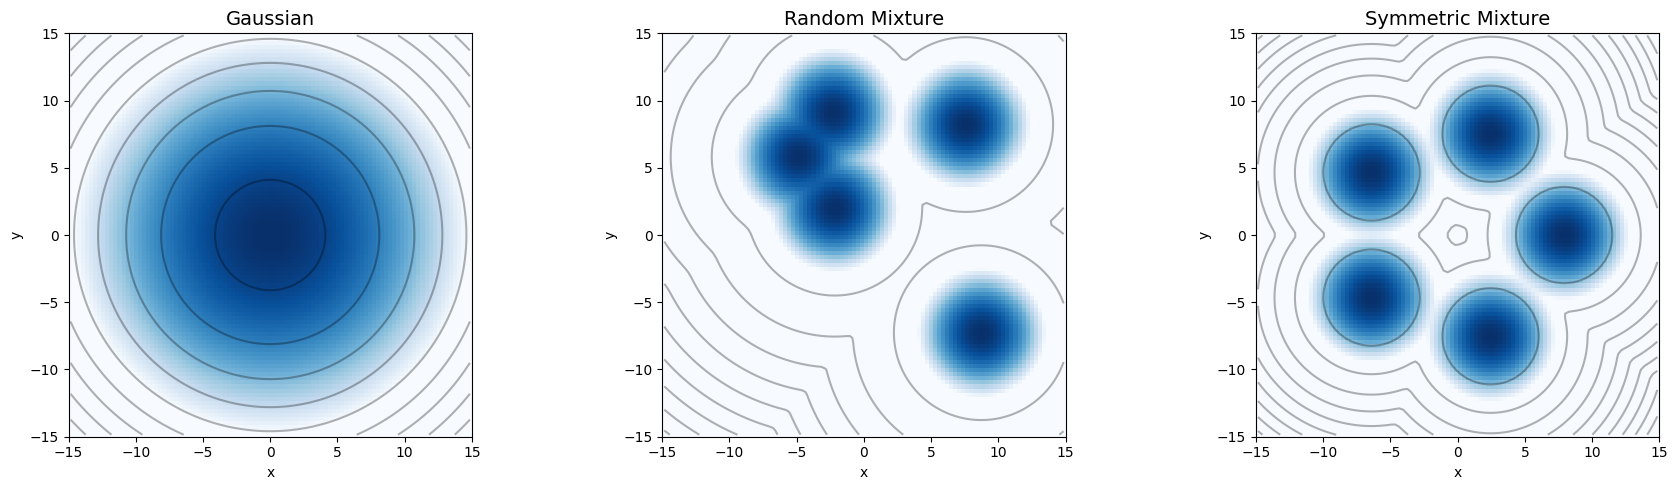

✓ Target densities visualized


In [5]:
# Part 3 - Visualize Target Densities
"""
Create and visualize different target distributions for Langevin dynamics.
"""

print("\n" + "=" * 60)
print("Part 3: Target Distributions")
print("=" * 60)

# Define targets
targets = {
    "Gaussian": Gaussian(
        mean=torch.zeros(2),
        cov=10 * torch.eye(2)
    ).to(device),
    
    "Random Mixture": GaussianMixture.random_2D(
        nmodes=5,
        std=1.0,
        scale=20.0,
        seed=42
    ).to(device),
    
    "Symmetric Mixture": GaussianMixture.symmetric_2D(
        nmodes=5,
        std=1.0,
        scale=8.0
    ).to(device)
}

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
bins = 100
scale = 15

for idx, (name, density) in enumerate(targets.items()):
    ax = axes[idx]
    ax.set_title(name, fontsize=14)
    
    # Heatmap
    imshow_density(density, bins, scale, device, ax,
                   vmin=-15, cmap='Blues')
    
    # Contours
    contour_density(density, bins, scale, device, ax,
                   colors='black', linestyles='solid',
                   alpha=0.3, levels=10)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    print(f"  {name}: visualized")

plt.tight_layout()
plt.show()

print("✓ Target densities visualized")


Part 4: Langevin Dynamics - Distribution Evolution
Configuration:
  • Target: 5-mode Gaussian mixture
  • Source: Broad Gaussian (σ²=20)
  • Langevin σ: 0.8
  • Particles: 10000
  • Time: [0, 10.0] with 2000 steps
  • Step size: 0.0050

Simulating...


Simulating: 100%|██████████| 1999/1999 [00:05<00:00, 334.00it/s]


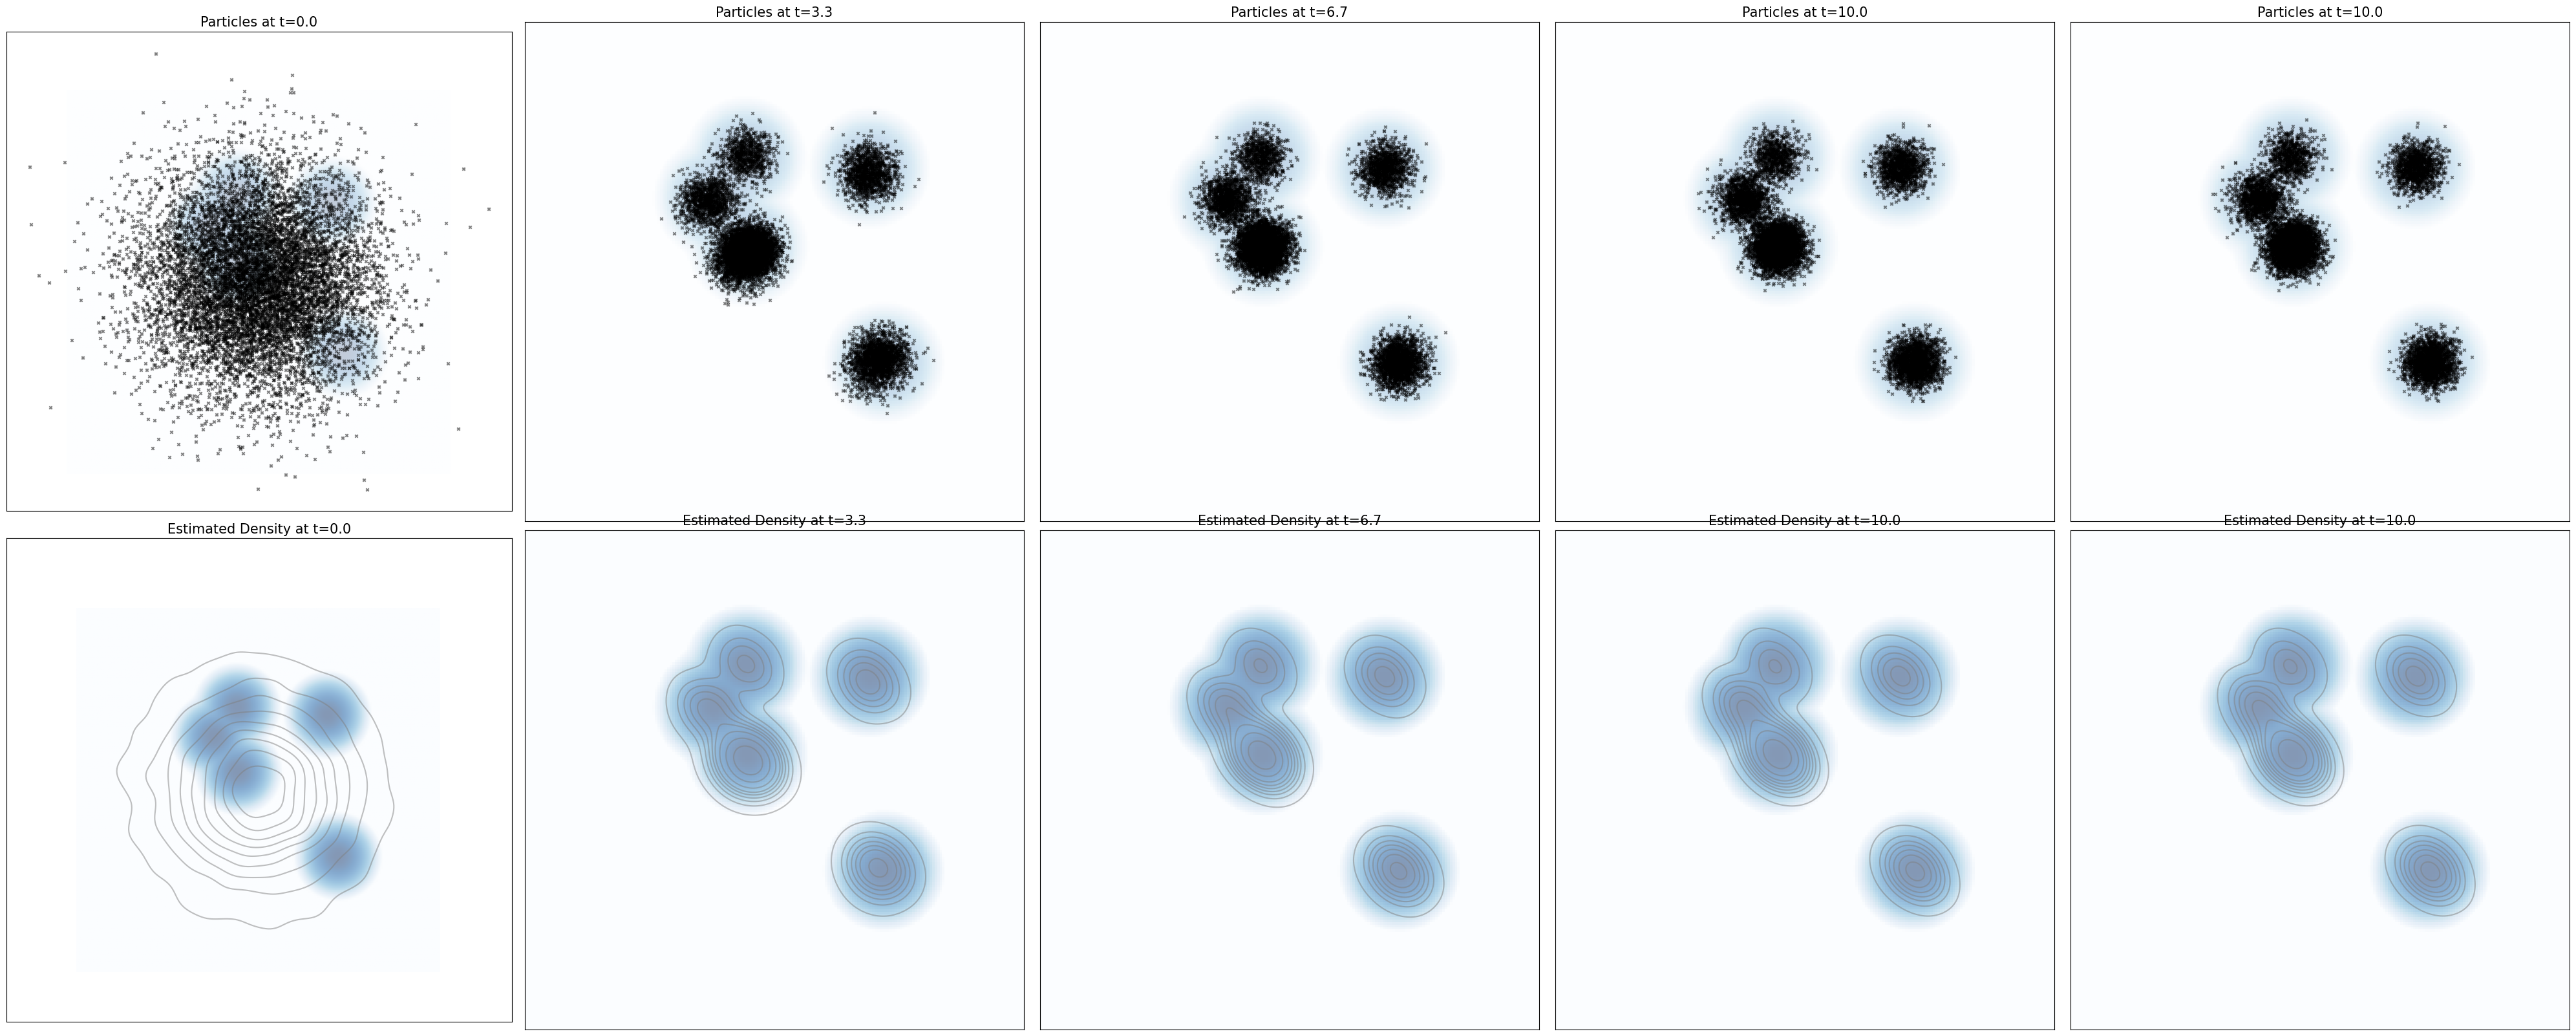

✓ Langevin dynamics visualization complete


In [6]:
# Part 4 - Langevin Dynamics
"""
Langevin Dynamics: dX_t = (σ²/2)∇log p(X_t) dt + σ dW_t

Samples from target distribution p(x) via score-based drift.
"""

print("\n" + "=" * 60)
print("Part 4: Langevin Dynamics - Distribution Evolution")
print("=" * 60)

# Setup
target = GaussianMixture.random_2D(
    nmodes=5,
    std=0.75,
    scale=15.0,
    seed=42
).to(device)

sigma = 0.8
langevin = LangevinSDE(sigma=sigma, density=target)
simulator = EulerMaruyamaSimulator(sde=langevin)

source = Gaussian(
    mean=torch.zeros(2),
    cov=20 * torch.eye(2)
).to(device)

# Simulation parameters
num_samples = 10000
simulation_time = 10.0
num_timesteps = 2000

print(f"Configuration:")
print(f"  • Target: 5-mode Gaussian mixture")
print(f"  • Source: Broad Gaussian (σ²=20)")
print(f"  • Langevin σ: {sigma}")
print(f"  • Particles: {num_samples}")
print(f"  • Time: [0, {simulation_time}] with {num_timesteps} steps")
print(f"  • Step size: {simulation_time/num_timesteps:.4f}")

# Run visualization
print("\nSimulating...")
plot_distribution_evolution(
    num_samples=num_samples,
    source_distribution=source,
    simulator=simulator,
    target_density=target,
    timesteps=torch.linspace(0, simulation_time, num_timesteps).to(device),
    plot_interval=num_timesteps // 3,  # 3 snapshots
    bins=200,
    scale=15,
    device=device
)

print("✓ Langevin dynamics visualization complete")


Part 5: Parameter Sensitivity (σ)

  Testing σ=0.3

  Testing σ=0.6

  Testing σ=1.0

  Testing σ=1.5


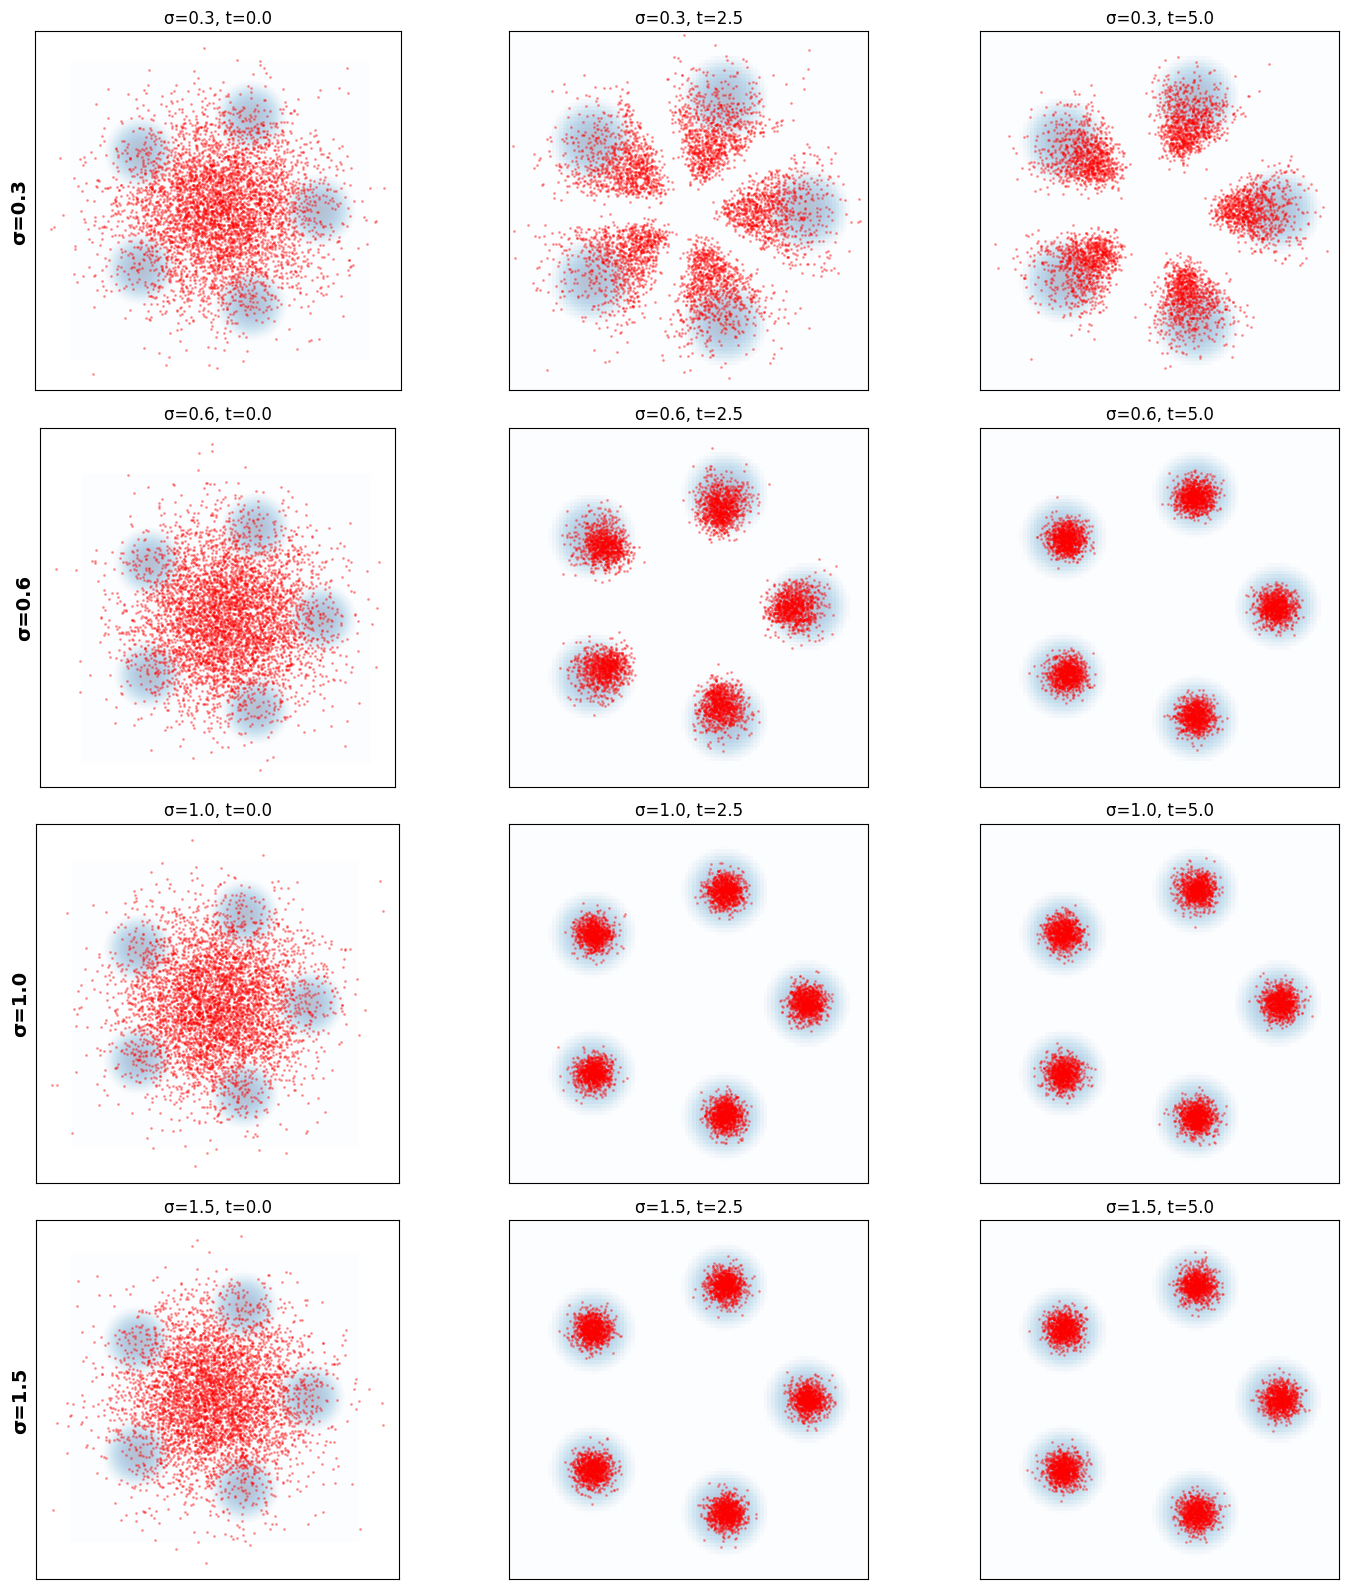


✓ Parameter sensitivity analysis complete
   Observation: Larger σ → faster exploration but noisier convergence


In [7]:
# Part 5 - Parameter Sensitivity Analysis
"""
Analyze how σ affects Langevin convergence.
"""

print("\n" + "=" * 60)
print("Part 5: Parameter Sensitivity (σ)")
print("=" * 60)

target = GaussianMixture.symmetric_2D(
    nmodes=5,
    std=0.6,
    scale=8.0
).to(device)

sigmas = [0.3, 0.6, 1.0, 1.5]
num_samples = 5000
simulation_time = 5.0

fig, axes = plt.subplots(len(sigmas), 3, figsize=(15, 4 * len(sigmas)))

for row_idx, sigma in enumerate(sigmas):
    print(f"\n  Testing σ={sigma}")
    
    langevin = LangevinSDE(sigma=sigma, density=target)
    simulator = EulerMaruyamaSimulator(sde=langevin)
    
    source = Gaussian(torch.zeros(2), 15 * torch.eye(2)).to(device)
    x0 = source.sample(num_samples)
    
    timesteps = torch.linspace(0, simulation_time, 1000).to(device)
    
    # Simulate to three time points
    snapshot_times = [0, len(timesteps) // 2, len(timesteps) - 1]
    
    for col_idx, t_idx in enumerate(snapshot_times):
        ax = axes[row_idx, col_idx]
        
        if t_idx == 0:
            samples = x0
            t_val = 0.0
        else:
            ts_partial = timesteps[:t_idx + 1]
            samples = simulator.simulate(x0.clone(), ts_partial)
            t_val = timesteps[t_idx].item()
        
        # Plot
        imshow_density(target, 100, 12, device, ax,
                      vmin=-15, alpha=0.3, cmap='Blues')
        ax.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(),
                  marker='.', color='red', alpha=0.3, s=5)
        ax.set_title(f'σ={sigma}, t={t_val:.1f}', fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if col_idx == 0:
            ax.set_ylabel(f'σ={sigma}', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Parameter sensitivity analysis complete")
print("   Observation: Larger σ → faster exploration but noisier convergence")

In [10]:
# Part 6 - Animation
"""
Create animation of distribution evolution.

Note: Requires ffmpeg to be installed.
"""

print("\n" + "=" * 60)
print("Part 6: Animation")
print("=" * 60)

try:
    from celluloid import Camera
    from IPython.display import display
    
    target = GaussianMixture.symmetric_2D(5, 0.6, 8).to(device)
    langevin = LangevinSDE(sigma=0.7, density=target)
    simulator = EulerMaruyamaSimulator(sde=langevin)
    source = Gaussian(torch.zeros(2), 15 * torch.eye(2)).to(device)
    
    print("Creating animation...")
    print("(This may take a minute)")
    
    video = animate_distribution_evolution(
        num_samples=5000,
        source_distribution=source,
        simulator=simulator,
        target_density=target,
        timesteps=torch.linspace(0, 10, 2000).to(device),
        animate_interval=30,
        bins=150,
        scale=12,
        device=device,
        save_path='langevin_animation.mp4'
    )
    
    display(video)
    print("✓ Animation saved to 'langevin_animation.mp4'")
    
except ImportError as e:
    print(f"⚠ Animation skipped: {e}")
    print("  Install: pip install celluloid")
    print("  And: conda install -c conda-forge ffmpeg")


Part 6: Animation
Creating animation...
(This may take a minute)


Simulating: 100%|██████████| 1999/1999 [00:03<00:00, 561.09it/s]


✓ Animation saved to 'langevin_animation.mp4'
